In [7]:
##############################################################
### Set up libraries and global variables
##############################################################
 
import pandas as pd
pd.options.mode.chained_assignment = None    # no warning message and no exception is raised
import numpy as np
import matplotlib.pyplot as plt
import scipy

#github_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_30/data/"
github_location = "./data/"
#github_location_styles = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
github_location_styles = "./styles/"
github_location_LFER_tables = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"

molwtH2SO4 = 98.079
molwtH2O = 18.015
densityH2SO4 = 1.83
densityH2O = 1.00


In [8]:
# Get Density data and make interpolation model

Data_File_Name = "models/p-model.csv"

Filename = github_location + Data_File_Name

df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

w = df["w"]
p = df["p"]


# Create interpolator function where a value of density is returned when given value of %H2SO4
density_interpolator_w = scipy.interpolate.make_interp_spline(w,p)

moles_H2SO4_in_100g = w / molwtH2SO4                # moles of H2SO4 in 100 g of mixture from % wt
volume_of_100g = 100 / p                            # volume in cm^3
M = moles_H2SO4_in_100g / volume_of_100g * 1000     # 1000 cm^3/L

density_interpolator_M = scipy.interpolate.make_interp_spline(M,p)

In [9]:
# Get a_H2O data

Data_File_Name = "models/aH2O_model.csv"

Filename = github_location + Data_File_Name

df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

m = df["m"].to_numpy()
aH2O = df["aH2O"].to_numpy()

w = (m*molwtH2SO4) / ((m*molwtH2SO4) + 1000) * 100   # w (%H2SO4)
mf = m / (m + 1000/molwtH2O)                         # mole fraction H2SO4
mfH2O = 1 - mf                                       # mole fraction H2O
gamma = aH2O / mfH2O                                 # apparent activity coeff H2O

moles_H2O = 1000/molwtH2O                            # moles of water
density = density_interpolator_w(w)                    # interpolated density of mixture a value of w
total_mass = m*molwtH2SO4 + 1000                     # total mass of mixture
volume = total_mass / density /1000                  # volume in litres
molar_H2O = moles_H2O/volume                         # moles H20 / volume of system = conc in M

molar_a_H2O = molar_H2O * gamma                      # molar activity of water

df1 = pd.DataFrame({"w":w,
              "M_aH2O": molar_a_H2O})


In [10]:
# get data from Cox

Data_File_Name = "01_Cox_Table3_activityH2OinH2SO4.csv"

Filename = github_location + Data_File_Name

df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

w = df["%H2SO4"].to_numpy()
log_aH2O = df["log aH2O"].to_numpy()

df_cox = pd.DataFrame({"w":w,
              "M_aH2O": np.power(10, log_aH2O)})


In [18]:
# get data from Cox

Data_File_Name = "01_Cox_Table4_activityH2OinH2SO4.csv"

Filename = github_location + Data_File_Name

df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

M = df["conc H2SO4 / (mole/L)"].to_numpy()
log_aH2O = df["log aH2O"].to_numpy()

density = density_interpolator_M(M)          # Density at each molar concentration

mass_of_1L = 1000 * density                  # g of 1 litre og mixture
mass_of_H2SO4_in_1L = M * molwtH2SO4
w = mass_of_H2SO4_in_1L / mass_of_1L * 100




df_cox_T4 = pd.DataFrame({"w":w,
              "M_aH2O": np.power(10, log_aH2O)})
w

array([9.83030142e-02, 9.77225008e-01, 2.42017765e+00, 4.76825020e+00,
       7.04778284e+00, 9.26228881e+00, 1.35127713e+01, 1.75436201e+01,
       2.13778524e+01, 2.50355167e+01, 2.85315695e+01, 3.18839534e+01,
       3.51064079e+01, 3.82056295e+01, 4.11913294e+01, 4.40721322e+01,
       4.68440785e+01, 4.95197798e+01, 5.20995925e+01, 5.45987405e+01,
       5.70133202e+01, 5.93592333e+01, 6.16354368e+01, 6.38487922e+01,
       6.60042356e+01, 6.81056253e+01, 7.01564065e+01, 7.21585862e+01,
       7.41213056e+01, 7.60464298e+01, 7.79435406e+01, 7.98252484e+01,
       8.17043113e+01, 8.35931868e+01, 8.55154842e+01, 8.75038982e+01,
       8.95718543e+01, 9.17317623e+01, 9.39972671e+01, 9.64173119e+01,
       9.92309799e+01])

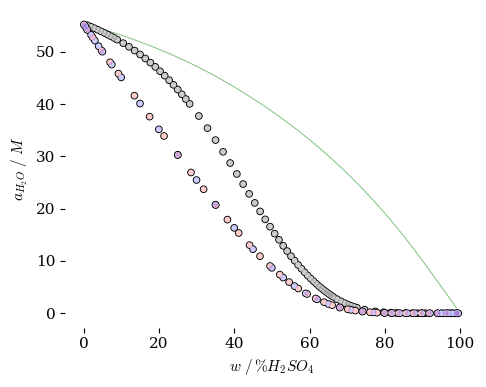

In [22]:
style = "tufte.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  

x_label = r"$w\ /\,\%H_2SO_4$" 
y_label = r"$a_{H_2O}\ /\;M$" 

ax.set(
#          title = Title0,       
          ylabel=y_label, 
          xlabel=x_label,                
#          xlim=[-2,102],                  
#          ylim=[1,-13]
       )



x = df1["w"]
y = np.log10(df1["M_aH2O"])
y = df1["M_aH2O"]

ax.scatter(x, y, 
          marker = "o", s = 30, 
          color = "black", edgecolors = "none", linewidths=0, 
          zorder = 3)

ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "white", edgecolors = "none", linewidths=0, 
          zorder = 4)

ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "black", edgecolors = "none", linewidths=0, 
          alpha = 0.2,
          zorder = 5)

ax.plot(x, molar_H2O, 
          marker = None,  
          color = "green", linewidth=0.7, 
          alpha = 0.5,
          zorder = 0)


x = df_cox_T4["w"]
y = np.log10(df_cox_T4["M_aH2O"])
y = df_cox_T4["M_aH2O"]

ax.scatter(x, y, 
          marker = "o", s = 30, 
          color = "black", edgecolors = "none", linewidths=0, 
          zorder = 6)

ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "white", edgecolors = "none", linewidths=0, 
          zorder = 7)

ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "red", edgecolors = "none", linewidths=0, 
          alpha = 0.2,
          zorder = 8)

x = df_cox["w"]
y = np.log10(df_cox["M_aH2O"])
y = df_cox["M_aH2O"]

ax.scatter(x, y, 
          marker = "o", s = 30, 
          color = "black", edgecolors = "none", linewidths=0, 
          zorder = 6)

ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "white", edgecolors = "none", linewidths=0, 
          zorder = 7)

ax.scatter(x, y, 
          marker = "o", s = 17, 
          color = "blue", edgecolors = "none", linewidths=0, 
          alpha = 0.2,
          zorder = 8)



plt.savefig("plots/plot_H1.pdf")
plt.show()
